In [1]:
import ee
import pandas as pd
import geemap
import numpy as no

from pprint import  pprint

import matplotlib.pyplot as plt
import seaborn as sns

In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\

In [2]:
ee.Initialize()

##### Define the basic parameters

In [3]:
region_cn = '西北'
region_en = 'xibei'

In [4]:
# import north_china_plain boundary
Region =  ee.FeatureCollection("users/wangjinzhulala/China_built_up/01_Boundary_shp/China_zone")\
            .filterMetadata('NAME1','equals',region_cn)

In [5]:
mask_years = [2016,2019]
original_range = ['2014_2016','2017_2019']

In [6]:
validation_path = 'users/wangjinzhulala/China_built_up/04_sample_train_test_split'
validation_sample = [ee.FeatureCollection(f"{validation_path}/Grid_select_{region_en}_{year}") for year in original_range]

In [7]:
img_path = 'users/wangjinzhulala/China_built_up/05_primary_classification'

##### compute the best urban-percentage of Sentinel-landcover dataset

In [8]:
sentine_urban = [ee.Image(f'COPERNICUS/Landcover/100m/Proba-V-C3/Global/{year}').select("urban-coverfraction") 
                 for year in mask_years]

In [9]:
# iterate each percentage to get the accuracy 

pct_acc = {}

for year,urban,sample in zip(mask_years,sentine_urban,validation_sample):
    
    validation_size = sample.size().getInfo()
    
    for i in range(5,100,5):
        
        img = urban.gte(i)
        stats = img.sampleRegions(collection = sample,
                                  properties = ['Built'],
                                  scale=100, 
                                  geometries = True)

        agree_num = stats.filter(ee.Filter.equals('Built',None,'urban-coverfraction')).size().getInfo()
        acc = round(agree_num/validation_size*100,2)

        pct_acc[(year,i)] = [acc]

        print(f'{year}_{i}-->{acc}')

2016_5-->98.1
2016_10-->97.41
2016_15-->97.07
2016_20-->96.55
2016_25-->96.55
2016_30-->96.21
2016_35-->95.86
2016_40-->95.52
2016_45-->95.52
2016_50-->94.66
2016_55-->94.31
2016_60-->93.97
2016_65-->93.62
2016_70-->93.1
2016_75-->92.07
2016_80-->90.69
2016_85-->89.66
2016_90-->88.97
2016_95-->85.34
2019_5-->98.45
2019_10-->97.59
2019_15-->97.07
2019_20-->96.72
2019_25-->96.9
2019_30-->96.55
2019_35-->96.21
2019_40-->95.69
2019_45-->95.52
2019_50-->94.66
2019_55-->94.31
2019_60-->93.97
2019_65-->93.62
2019_70-->93.1
2019_75-->92.41
2019_80-->91.21
2019_85-->90.34
2019_90-->90.17
2019_95-->86.38


In [10]:
accuracy_df = pd.DataFrame(pct_acc).T
accuracy_df.reset_index(inplace=True)
accuracy_df.columns = ['year','mask_val','accuracy']


<AxesSubplot:xlabel='mask_val', ylabel='accuracy'>

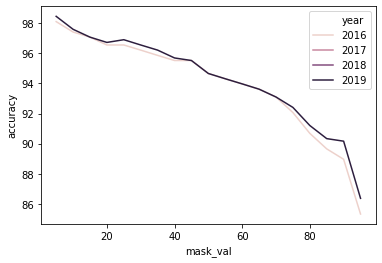

In [11]:
sns.lineplot(data=accuracy_df,x='mask_val',y='accuracy',hue='year')

In [12]:
threshold = 20

##### use the sentinel-urban as a binary mask to erase the incorect pixel in the classification of [2014-2016, 2017-2019]

In [13]:
# fetch the original img

original_maps = []

for year in original_range:
    
    imgs = [ee.Image(f"{img_path}/Spectrum_Normalize_Fourier_Terrain_Meterology_{region_en}_{year}_{seed}") 
            for seed in range(10)]
    
    ten_folds_check = ee.ImageCollection(imgs).sum().gte(4)
    
    original_maps.append(ten_folds_check)


# use the threshold to construct the urban mask
urban_masks = [img.gte(threshold).clip(Region) for img in sentine_urban]

# use the mask to update original img
clasification_update = [original.multiply(mask) for original,mask in zip(original_maps,urban_masks)]
clasification_update[0] = clasification_update[0].multiply(clasification_update[1])

In [14]:
Map = geemap.Map()

Map.add_basemap('HYBRID')

Map.addLayer(original_maps[0],         {'min':0,'max':1},'original_2014_2016')
Map.addLayer(ee.Image(urban_masks[0]), {'min':0,'max':1},'mask_2016')
Map.addLayer(clasification_update[0],  {'min':0,'max':1},'update_2014_2016')

Map.addLayer(original_maps[1],         {'min':0,'max':1},'original_2017_2019')
Map.addLayer(ee.Image(urban_masks[1]), {'min':0,'max':1},'mask_2019')
Map.addLayer(clasification_update[1],  {'min':0,'max':1},'update_2017_2019')

Map.centerObject(Region,10)
Map

Map(center=[45.60284502652854, 126.43494959262036], controls=(WidgetControl(options=['position'], widget=HBox(…